1) Importar librerías

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
import openpyxl
from sklearn.preprocessing import LabelEncoder
import hmmlearn.hmm as hmm

2) Carga de Datos

In [4]:
bd = pd.read_excel(r"C:\Users\leand\OneDrive - PhD in Engineering\3. Doctoral proposal\Propuesta_V5_22_10_2025\Data_Ndvi.xlsx")

In [5]:
bd.head()

,Fecha,NDVI,NDVI_imputed,NDVI_prior_feat,NDVI_pred_model,NDVI_final,NDVI_fuente,Precipitaciones (mm),rain_sum_7,rain_sum_7_log1p,...,GDD_sum_14,GDD_sum_30,Humedad_(%),hum_ma_7,hum_ma_14,hum_lag1,doy_sin,doy_cos,NDVI_missing,days_since_last_NDVI
0,2009-03-21,NaN,NaN,0.642129,NaN,0.642129,prior_blend,5.4,5.4,1.856298,...,8.0,8.0,89.5,89.500000,89.500000,NaN,0.980575,0.196143,1,5.902633
1,2009-03-22,NaN,NaN,0.490953,NaN,0.490953,prior_blend,16.5,21.9,3.131137,...,16.0,16.0,97.0,93.250000,93.250000,89.5,0.983798,0.179281,1,5.902633
2,2009-03-23,NaN,NaN,0.465812,NaN,0.465812,prior_blend,11.8,33.7,3.546740,...,24.5,24.5,98.0,94.833333,94.833333,97.0,0.986731,0.162366,1,5.902633
3,2009-03-24,NaN,NaN,0.390806,NaN,0.390806,prior_blend,20.5,54.2,4.010963,...,33.0,33.0,94.5,94.750000,94.750000,98.0,0.989372,0.145404,1,5.902633
4,2009-03-25,NaN,NaN,0.339206,NaN,0.339206,prior_blend,17.8,72.0,4.290459,...,41.0,41.0,94.0,94.600000,94.600000,94.5,0.991723,0.128398,1,5.902633


3) Selección de variables climáticas (NDVI, Precipitación, Tmax, Tmin, Humedad)

In [6]:
feature = [1, 7, 18, 19, 27]
XDB = bd.iloc[:, feature].copy()

In [7]:
XDB.head()

,NDVI,Precipitaciones (mm),Máx_grado_C,Mín_grado_C,Humedad_(%)
0,NaN,5.4,21,15,89.5
1,NaN,16.5,21,15,97.0
2,NaN,11.8,21,16,98.0
3,NaN,20.5,22,15,94.5
4,NaN,17.8,21,15,94.0


4) Limpieza de datos: Conversión a numérico y filtrado de registros válidos (NDVI > 0)

In [8]:
XDB['NDVI'] = pd.to_numeric(XDB['NDVI'], errors='coerce')

# 2) Filas con NDVI > 0 (no es NaN)
mask_ndvi = XDB['NDVI'].notna() & (XDB['NDVI']>0)

XDB_low_ndvi = XDB[mask_ndvi].copy()

In [9]:
XDB_low_ndvi.shape

(120, 5)

In [10]:
XDB_low_ndvi

,NDVI,Precipitaciones (mm),Máx_grado_C,Mín_grado_C,Humedad_(%)
2869,0.44,0.0,25,11,78.5
2889,0.52,0.0,27,11,65.0
2929,0.65,8.1,25,14,79.5
2999,0.68,1.4,28,12,67.0
3009,0.64,16.2,26,10,68.0
...,...,...,...,...,...
5734,0.56,8.3,22,12,77.5
5739,0.67,5.1,21,12,77.5
5779,0.70,1.0,23,10,69.0
5784,0.69,2.2,22,10,73.5


5) Ingeniería de Características: Transformación logarítmica de la precipitación (rain_log) para normalizar su distribución y construcción de la matriz de observación $Y$.

In [11]:
# Construcción del vector de observación
Y = pd.DataFrame({
    "ndvi": XDB_low_ndvi["NDVI"],                        
    "rain_log": np.log1p(XDB_low_ndvi["Precipitaciones (mm)"]),  # transforma lluvia
    "tmax": XDB_low_ndvi["Máx_grado_C"],
    "tmin": XDB_low_ndvi["Mín_grado_C"],
    "hum": XDB_low_ndvi["Humedad_(%)"]
}).dropna()   # quitar filas con NaN en estas 5

X = Y.to_numpy()   # matriz (N, d) donde d = 5


6) Estandarización: Uso de StandardScaler para que todas las variables tengan media 0 y desviación estándar 1 (crucial para HMM Gaussiano)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  
d = X_scaled.shape[1]
N = X_scaled.shape[0]


7) Entrenamiento iterativo de HMM Gaussianos con diferentes números de estados ($K=1..6$) utilizando criterios de información (AIC y BIC).

In [13]:
from hmmlearn.hmm import GaussianHMM
import numpy as np

def num_params_gaussian_hmm(K, d):
    return (K - 1) + K*(K - 1) + K*d + K * (d*(d+1)//2)

Ks = range(1, 7)   # por ejemplo 1 a 6 estados
resultados_hmm = []

for K in Ks:
    # Varios reinicios para evitar óptimos locales
    best_logL = -np.inf
    best_model = None
    for seed in range(5):
        model = GaussianHMM(
            n_components=K,
            covariance_type="full",
            n_iter=1000,
            random_state=seed
        )
        model.fit(X_scaled)
        logL = model.score(X_scaled)
        if logL > best_logL:
            best_logL = logL
            best_model = model
    
    p = num_params_gaussian_hmm(K, d)
    BIC = -2 * best_logL + p * np.log(N)
    AIC = 2 * p - 2 * best_logL
    
    resultados_hmm.append({
        "K": K,
        "logL": best_logL,
        "AIC": AIC,
        "BIC": BIC,
        "model": best_model
    })
    print(f"K={K} | logL={best_logL:.1f} | AIC={AIC:.1f} | BIC={BIC:.1f}")


K=1 | logL=-730.6 | AIC=1501.3 | BIC=1557.0
K=2 | logL=-629.2 | AIC=1344.3 | BIC=1464.2


Model is not converging.  Current: -544.5106025911258 is not greater than -543.6996723756923. Delta is -0.8109302154334728
Model is not converging.  Current: -559.6385111498028 is not greater than -499.2720325532885. Delta is -60.36647859651424


K=3 | logL=-545.9 | AIC=1227.8 | BIC=1417.3
K=4 | logL=-499.2 | AIC=1188.5 | BIC=1453.3


Model is not converging.  Current: -538.4576736133357 is not greater than -497.2140819285384. Delta is -41.24359168479731


K=5 | logL=-553.8 | AIC=1355.6 | BIC=1701.3
K=6 | logL=-487.3 | AIC=1284.5 | BIC=1716.6


8) Selección automática del mejor modelo basado en el menor BIC.

In [14]:
mejor_BIC = min(resultados_hmm, key=lambda r: r["BIC"])
K_opt = mejor_BIC["K"]
hmm_opt = mejor_BIC["model"]

print(f"\nMejor K según BIC: {K_opt}")



Mejor K según BIC: 3


9. Decodificación de estados (Algoritmo de Viterbi) y obtención de las medias de los centroides.

In [15]:
# Secuencia de estados más probable (Viterbi)
states_seq = hmm_opt.predict(X_scaled)   # array de longitud N con valores 0..K-1

# Para interpretar cada estado:
means = hmm_opt.means_    # matriz (K_opt, d)
print("Medias por estado (en escala estandarizada):")
print(means)


Medias por estado (en escala estandarizada):
[[ 0.13880187  0.1481563  -0.58837412  0.08960057  0.29857121]
 [-0.02757375 -1.17275601  1.15514333  1.05042131 -0.72491757]
 [-0.2609664  -0.16422154  1.00239736 -0.27528341 -0.49479398]]


10. Análisis de las matrices de covarianza (full) para entender la relación entre variables dentro de cada estado.

In [16]:
import numpy as np

# Tipo de covarianza del modelo: 'full', 'diag', 'spherical', 'tied', etc.
cov_type = hmm_opt.covariance_type
print("Tipo de covarianza:", cov_type)

# Extraer covarianzas por estado
if cov_type == "full":
    # shape: (K_opt, d, d)
    covariances = hmm_opt.covars_
elif cov_type == "diag":
    # shape original: (K_opt, d)  -> la pasamos a matrices diagonales (K_opt, d, d)
    covariances = np.array([np.diag(c) for c in hmm_opt.covars_])
elif cov_type == "spherical":
    # una sola varianza por estado -> σ² * I
    covariances = np.array([np.eye(hmm_opt.n_features) * c for c in hmm_opt.covars_])
elif cov_type == "tied":
    # una sola matriz de covarianza compartida por todos los estados
    # replicamos para tener forma (K_opt, d, d)
    covariances = np.array([hmm_opt.covars_] * hmm_opt.n_components)
else:
    raise ValueError(f"Tipo de covarianza no soportado: {cov_type}")

print("\nCovarianzas por estado (en escala estandarizada):")
for k, Sigma in enumerate(covariances):
    print(f"\nEstado {k}:")
    print(Sigma)


Tipo de covarianza: full

Covarianzas por estado (en escala estandarizada):

Estado 0:
[[ 0.93501875 -0.30514154  0.09634543 -0.26850197 -0.25027073]
 [-0.30514154  1.03366578 -0.48177365  0.31080523  0.73577667]
 [ 0.09634543 -0.48177365  0.42353362 -0.13975629 -0.52020626]
 [-0.26850197  0.31080523 -0.13975629  0.73752157  0.38838976]
 [-0.25027073  0.73577667 -0.52020626  0.38838976  0.84041291]]

Estado 1:
[[ 0.83864894  0.02078067  0.43119968  0.51614827 -1.07267534]
 [ 0.02078067  0.00836045  0.0025      0.09855539 -0.01029807]
 [ 0.43119968  0.0025      0.29414262  0.33446115 -0.56782509]
 [ 0.51614827  0.09855539  0.33446115  2.45854828 -0.49431413]
 [-1.07267534 -0.01029807 -0.56782509 -0.49431413  1.40603874]]

Estado 2:
[[ 1.03556475 -0.30876027  0.15018239  0.05938315 -0.07305472]
 [-0.30876027  0.82973894 -0.25587505  0.08642971  0.3350668 ]
 [ 0.15018239 -0.25587505  0.37063629 -0.23544213 -0.43482627]
 [ 0.05938315  0.08642971 -0.23544213  1.1522313   0.54810295]
 [-0.07

11. Transformación inversa de los parámetros para interpretar los resultados en las unidades originales

In [17]:
means_original = scaler.inverse_transform(means)
medias_estado = pd.DataFrame(
    means_original,
    columns=Y.columns
)
print(medias_estado)


       ndvi  rain_log       tmax       tmin        hum
0  0.628158  1.407800  22.434211  12.394737  77.269739
1  0.600000  0.045580  27.000000  13.500000  68.875000
2  0.560500  1.085653  26.600001  11.974999  70.762493


In [18]:
# 1. Filtrar solo filas con NDVI observado (crudo, sin imputar)
df_obs = XDB_low_ndvi[["NDVI",
             "Precipitaciones (mm)",
             "Máx_grado_C",
             "Mín_grado_C",
             "Humedad_(%)"]].copy()

df_obs = df_obs.dropna(subset=["NDVI"])

print(df_obs.head())
print(df_obs.shape)   # debería darte (120, 6)


      NDVI  Precipitaciones (mm)  Máx_grado_C  Mín_grado_C  Humedad_(%)
2869  0.44                   0.0           25           11         78.5
2889  0.52                   0.0           27           11         65.0
2929  0.65                   8.1           25           14         79.5
2999  0.68                   1.4           28           12         67.0
3009  0.64                  16.2           26           10         68.0
(120, 5)


In [19]:
import numpy as np
import pandas as pd

Y = pd.DataFrame({
    "ndvi": df_obs["NDVI"].values,
    "rain_log": np.log1p(df_obs["Precipitaciones (mm)"].values),
    "tmax": df_obs["Máx_grado_C"].values,
    "tmin": df_obs["Mín_grado_C"].values,
    "hum": df_obs["Humedad_(%)"].values,
}, index=df_obs.index)

print(Y.head())
print(Y.shape)   # aquí sí esperas algo tipo (120, 5)


      ndvi  rain_log  tmax  tmin   hum
2869  0.44  0.000000    25    11  78.5
2889  0.52  0.000000    27    11  65.0
2929  0.65  2.208274    25    14  79.5
2999  0.68  0.875469    28    12  67.0
3009  0.64  2.844909    26    10  68.0
(120, 5)


12. Asignación de las etiquetas de estado a los datos originales.

In [20]:
Y_estados = Y.copy()
Y_estados["estado_hmm"] = states_seq

print("Primeras filas de Y_estados:")
print(Y_estados.head())

Primeras filas de Y_estados:
      ndvi  rain_log  tmax  tmin   hum  estado_hmm
2869  0.44  0.000000    25    11  78.5           1
2889  0.52  0.000000    27    11  65.0           2
2929  0.65  2.208274    25    14  79.5           2
2999  0.68  0.875469    28    12  67.0           2
3009  0.64  2.844909    26    10  68.0           2


13. Estadísticas descriptivas (Media, Std, Min, Max) agrupadas por estado.

In [21]:
vars_cols = ["ndvi", "rain_log", "tmax", "tmin", "hum"]

tabla_resumen = (
    Y_estados
      .groupby("estado_hmm")[vars_cols]
      .agg(["mean", "std", "min", "max"])
)

print("=== Resumen por estado (media / std / min / max) ===")
print(tabla_resumen)


=== Resumen por estado (media / std / min / max) ===
                ndvi                        rain_log                           \
                mean       std   min   max      mean       std  min       max   
estado_hmm                                                                      
0           0.628158  0.164728  0.04  0.81  1.407800  1.055387  0.0  3.675744   
1           0.600000  0.178699  0.44  0.82  0.045580  0.091161  0.0  0.182322   
2           0.560500  0.174399  0.07  0.80  1.085654  0.951209  0.0  3.122365   

                 tmax                         tmin                    \
                 mean       std min max       mean       std min max   
estado_hmm                                                             
0           22.434211  1.715308  18  26  12.394737  0.994370  10  14   
1           27.000000  1.632993  25  29  13.500000  2.081666  11  16   
2           26.600000  1.614041  24  29  11.975000  1.250385  10  15   

                  hum      

In [22]:
tabla_cuantiles = (
    Y_estados
      .groupby("estado_hmm")[vars_cols]
      .quantile([0.1, 0.25, 0.5, 0.75, 0.9])
      .unstack(level=-1)
)

print("\n=== Cuantiles 0.1, 0.25, 0.5, 0.75, 0.9 por estado ===")
print(tabla_cuantiles)



=== Cuantiles 0.1, 0.25, 0.5, 0.75, 0.9 por estado ===
             ndvi                               rain_log                      \
             0.10    0.25   0.50    0.75   0.90     0.10      0.25      0.50   
estado_hmm                                                                     
0           0.455  0.5500  0.675  0.7525  0.790      0.0  0.421799  1.504077   
1           0.449  0.4625  0.570  0.7075  0.775      0.0  0.000000  0.000000   
2           0.355  0.4475  0.590  0.6850  0.743      0.0  0.160569  1.045932   

                                ...  tmin                            hum  \
                0.75      0.90  ...  0.10  0.25  0.50  0.75  0.90   0.10   
estado_hmm                      ...                                        
0           2.253910  2.904161  ...  11.0  12.0  12.0  13.0  14.0  68.75   
1           0.045580  0.127625  ...  11.6  12.5  13.5  14.5  15.4  57.75   
2           1.795892  2.289282  ...  11.0  11.0  12.0  13.0  14.0  62.60   

      

14. Visualización: Boxplots para comparar la distribución de las variables climáticas y NDVI en cada estado.

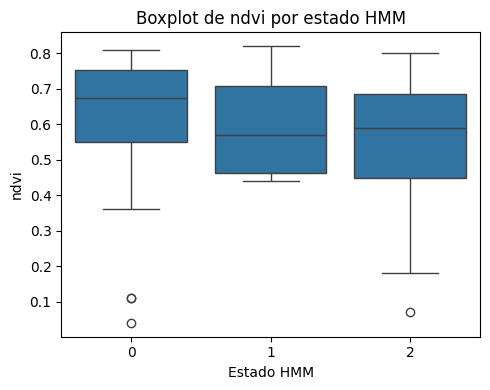

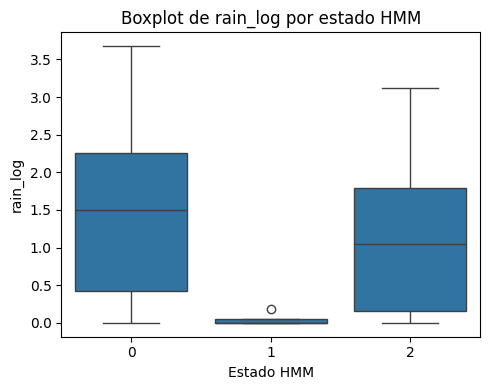

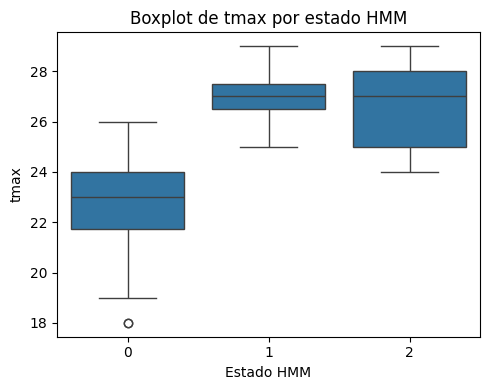

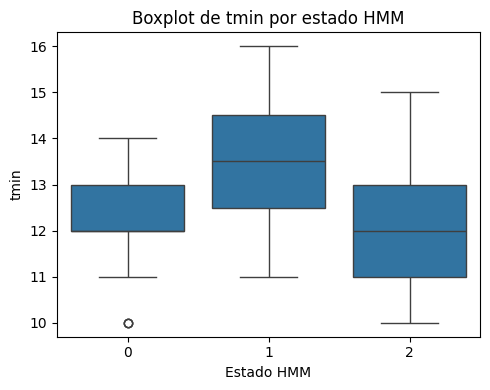

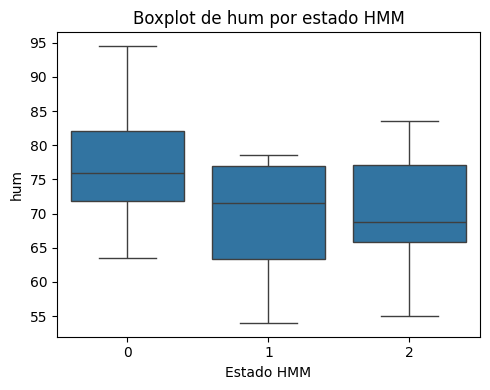

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

vars_cols = ["ndvi", "rain_log", "tmax", "tmin", "hum"]

for var in vars_cols:
    plt.figure(figsize=(5, 4))
    sns.boxplot(data=Y_estados, x="estado_hmm", y=var)
    plt.title(f"Boxplot de {var} por estado HMM")
    plt.xlabel("Estado HMM")
    plt.tight_layout()
    plt.show()


In [24]:
print(X_scaled.shape)          # (N, 5)  → 5 variables
print(hmm_opt.means_.shape)    # (K, 5)  → media de 5 variables por estado
print(hmm_opt.covars_.shape)   # (K, 5, 5) → covarianzas 5x5 por estado


(120, 5)
(3, 5)
(3, 5, 5)


15. Verificación de convergencia del algoritmo Baum-Welch.

In [25]:
print("¿Convergió?:", hmm_opt.monitor_.converged)
print("Iteraciones usadas:", hmm_opt.monitor_.iter)
print("LogL final:", hmm_opt.monitor_.history[-1])


¿Convergió?: True
Iteraciones usadas: 20
LogL final: -544.5106025911258
